In [1]:
# import statements

import xarray as xrs
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy

In [41]:
# function because some of the simulations have a messed-up calendar
def fix_xtime(ds_in: xr.Dataset) -> xr.Dataset:
    ds_in.XTIME.attrs["units"] = "minutes since 2021-09-01 20:00:00"
    ds_in.XTIME.attrs["description"] = "minutes since 2021-09-01 20:00:00"
    return(ds_in)

In [54]:
runs = xr.decode_cf(
    xr.open_mfdataset("/mnt/drive2/wof-runs/20Z/wrfwof*.01",preprocess=fix_xtime,
                         decode_times=False,combine="nested",concat_dim='Time')
                         )


In [59]:
UH = runs.UP_HELI_MAX02

In [70]:
UH.XTIME.load()

<xarray.DataArray 'XTIME' (Time: 73)>
array(['2021-09-01T20:00:00.000000000', '2021-09-01T20:05:00.000000000',
       '2021-09-01T20:10:00.000000000', '2021-09-01T20:15:00.000000000',
       '2021-09-01T20:20:00.000000000', '2021-09-01T20:25:00.000000000',
       '2021-09-01T20:30:00.000000000', '2021-09-01T20:35:00.000000000',
       '2021-09-01T20:40:00.000000000', '2021-09-01T20:45:00.000000000',
       '2021-09-01T20:50:00.000000000', '2021-09-01T20:55:00.000000000',
       '2021-09-01T21:00:00.000000000', '2021-09-01T21:05:00.000000000',
       '2021-09-01T21:10:00.000000000', '2021-09-01T21:15:00.000000000',
       '2021-09-01T21:20:00.000000000', '2021-09-01T21:25:00.000000000',
       '2021-09-01T21:30:00.000000000', '2021-09-01T21:35:00.000000000',
       '2021-09-01T21:40:00.000000000', '2021-09-01T21:45:00.000000000',
       '2021-09-01T21:50:00.000000000', '2021-09-01T21:55:00.000000000',
       '2021-09-01T22:00:00.000000000', '2021-09-01T22:05:00.000000000',
       '2021-09-01T22:10:00.000000000', '2021-09-01T22:15:00.000000000',
       '2021-09-01T22:20:00.000000000', '2021-09-01T22:25:00.000000000',
       '2021-09-01T22:30:00.000000000', '2021-09-01T22:35:00.000000000',
       '2021-09-01T22:40:00.000000000', '2021-09-01T22:45:00.000000000',
       '2021-09-01T22:50:00.000000000', '2021-09-01T22:55:00.000000000',
       '2021-09-01T23:00:00.000000000', '2021-09-01T23:05:00.000000000',
       '2021-09-01T23:10:00.000000000', '2021-09-01T23:15:00.000000000',
       '2021-09-01T23:20:00.000000000', '2021-09-01T23:25:00.000000000',
       '2021-09-01T23:30:00.000000000', '2021-09-01T23:35:00.000000000',
       '2021-09-01T23:40:00.000000000', '2021-09-01T23:45:00.000000000',
       '2021-09-01T23:50:00.000000000', '2021-09-01T23:55:00.000000000',
       '2021-09-02T00:00:00.000000000', '2021-09-02T00:05:00.000000000',
       '2021-09-02T00:10:00.000000000', '2021-09-02T00:15:00.000000000',
       '2021-09-02T00:20:00.000000000', '2021-09-02T00:25:00.000000000',
       '2021-09-02T00:30:00.000000000', '2021-09-02T00:35:00.000000000',
       '2021-09-02T00:40:00.000000000', '2021-09-02T00:45:00.000000000',
       '2021-09-02T00:50:00.000000000', '2021-09-02T00:55:00.000000000',
       '2021-09-02T01:00:00.000000000', '2021-09-02T01:05:00.000000000',
       '2021-09-02T01:10:00.000000000', '2021-09-02T01:15:00.000000000',
       '2021-09-02T01:20:00.000000000', '2021-09-02T01:25:00.000000000',
       '2021-09-02T01:30:00.000000000', '2021-09-02T01:35:00.000000000',
       '2021-09-02T01:40:00.000000000', '2021-09-02T01:45:00.000000000',
       '2021-09-02T01:50:00.000000000', '2021-09-02T01:55:00.000000000',
       '2021-09-02T02:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    XTIME    (Time) datetime64[ns] 2021-09-01T20:00:00 ... 2021-09-02T02:00:00
Dimensions without coordinates: Time
Attributes:
    FieldType:    104
    MemoryOrder:  0  
    description:  minutes since 2021-09-01 20:00:00
    stagger:      
    _metpy_axis:  time

In [2]:
# read in data
runs = xr.open_mfdataset("/mnt/drive2/wof-runs/20Z/wrfwof*.01",combine='nested',
                         concat_dim='Time',decode_times=False)

In [30]:
wof1 = xr.open_dataset("/mnt/drive2/wof-runs/20Z/wrfwof_d01_2021-09-01_20:00:00.01")
wof2 = xr.open_dataset("/mnt/drive2/wof-runs/20Z/wrfwof_d01_2021-09-01_20:05:00.01",
                       decode_cf=False)

In [31]:
wof1.XTIME.attrs

{'FieldType': 104,
 'MemoryOrder': '0  ',
 'description': 'minutes since 2021-09-01 20:00:00',
 'stagger': ''}

In [32]:
wof2.XTIME.attrs.update({"units":"minutes since 2021-09-01 20:00:00",
                         "description":"minutes since 2021-09-01 20:00:00"
                         })

In [33]:
xr.decode_cf(wof2)

<xarray.Dataset>
Dimensions:              (Time: 1, south_north: 300, west_east: 300,
                          bottom_top: 50, bottom_top_stag: 51,
                          soil_layers_stag: 9, west_east_stag: 301,
                          south_north_stag: 301)
Coordinates:
    XLAT                 (Time, south_north, west_east) float32 ...
    XLONG                (Time, south_north, west_east) float32 ...
    XTIME                (Time) datetime64[ns] ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/79)
    ALBEDO               (Time, south_north, west_east) float32 ...
    CLDFRA               (Time, bottom_top, south_north, west_east) float32 ...
    COMPOSITE_REFL_10CM  (Time, south_north, west_east) float32 ...
    COSALPHA             (Time, south_north, west_east) float32 ...
    COSZEN               (Time, south_north, west_east) float32 ...
    EMISS                (Time, south_north, west_east) float32 ...
    ...                   ...
    VT_DBZ_WT            (Time, bottom_top, south_north, west_east) float32 ...
    W                    (Time, bottom_top_stag, south_north, west_east) float32 ...
    WSPD10MAX            (Time, south_north, west_east) float32 ...
    WSPD80               (Time, south_north, west_east) float32 ...
    W_UP_MAX             (Time, south_north, west_east) float32 ...
    XLAND                (Time, south_north, west_east) float32 ...
Attributes: (12/74)
    TITLE:                            OUTPUT FROM WRF V3.9pre#2 MODEL
    START_DATE:                      2021-09-01_20:00:00
    WEST-EAST_GRID_DIMENSION:        301
    SOUTH-NORTH_GRID_DIMENSION:      301
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3000.0
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      -1
    ETAC:                            0.0
    history:                         Tue Sep 21 20:04:34 2021: /scratch/softw...
    NCO:                             4.6.7

In [5]:
test = xr.open_dataset("/mnt/drive2/wof-runs/20Z/wrfwof_d01_2021-09-01_20:00:00.01")
test

<xarray.Dataset>
Dimensions:              (Time: 1, south_north: 300, west_east: 300,
                          bottom_top: 50, bottom_top_stag: 51,
                          soil_layers_stag: 9, west_east_stag: 301,
                          south_north_stag: 301)
Coordinates:
    XLAT                 (Time, south_north, west_east) float32 ...
    XLONG                (Time, south_north, west_east) float32 ...
    XTIME                (Time) datetime64[ns] ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/79)
    ALBEDO               (Time, south_north, west_east) float32 ...
    CLDFRA               (Time, bottom_top, south_north, west_east) float32 ...
    COMPOSITE_REFL_10CM  (Time, south_north, west_east) float32 ...
    COSALPHA             (Time, south_north, west_east) float32 ...
    COSZEN               (Time, south_north, west_east) float32 ...
    EMISS                (Time, south_north, west_east) float32 ...
    ...                   ...
    VT_DBZ_WT            (Time, bottom_top, south_north, west_east) float32 ...
    W                    (Time, bottom_top_stag, south_north, west_east) float32 ...
    WSPD10MAX            (Time, south_north, west_east) float32 ...
    WSPD80               (Time, south_north, west_east) float32 ...
    W_UP_MAX             (Time, south_north, west_east) float32 ...
    XLAND                (Time, south_north, west_east) float32 ...
Attributes: (12/74)
    TITLE:                            OUTPUT FROM WRF V3.9pre#2 MODEL
    START_DATE:                      2021-09-01_20:00:00
    WEST-EAST_GRID_DIMENSION:        301
    SOUTH-NORTH_GRID_DIMENSION:      301
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3000.0
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      -1
    ETAC:                            0.0
    history:                         Tue Sep 21 20:04:26 2021: /scratch/softw...
    NCO:                             4.6.7

/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


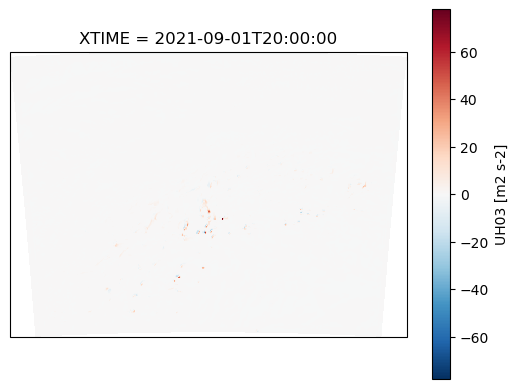

In [21]:
p = wof.UH03.isel(Time=0).plot(x="XLONG",y="XLAT",
                               subplot_kws=dict(projection=ccrs.LambertConformal(),
                                                transform=ccrs.PlateCarree()))
# p.axes.set_extent(region)
# p.axes.add_feature(cfeature.STATES)
# p.axes.coastlines()